In [27]:
import os 
import numpy as np
import pandas as pd
import numpy as np

from classes.matlab_reader import matlab_reader
from classes.grid_funcs import map_grid,dataset,data_wizard
from dotenv import load_dotenv   #for python-dotenv method
from datetime import datetime

pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', 500)


In [28]:
# Get Temperature Data]
def generate_dataset(path='/Users/joaojesus/Desktop/final_year_proj/PROCESSED_ERA5_ONLINE/COMPRESSED/WIND_EASTWARD/',
                    geo_filtering = {'min_lat':60,'max_lat':80,'min_lon':-180, 'max_lon': 180},
                    year_selection = '1995',
                    data_name = 'wind_eastward'):
    
    grid = map_grid(grid_size=None, source = 'era5')
    wizard = data_wizard()
    res_mean = []
    res_mean_selection = []
    file_names = []
    files = os.listdir(path)
    files.sort()
    for file in files:
        if file[:4] == year_selection:
            temperature = np.load(path + file)['arr_0']

            select_area_indexer = grid.select_area_indexer(
                min_lat= geo_filtering['min_lat'],
                max_lat= geo_filtering['max_lat'],
                min_lon= geo_filtering['min_lon'],
                max_lon= geo_filtering['max_lat'])

            data = wizard.data_filtering(select_area_indexer = select_area_indexer ,data = temperature)

            file_names.append(file[:10])
            res_mean.append(np.nanmean(temperature))
            res_mean_selection.append(np.nanmean(data))

    df = pd.DataFrame(data={
        'dates' : file_names,
        f'{data_name}_mean' : res_mean,
        f'{data_name}_mean_selection' : res_mean_selection
    })
    
    df['dates'] = pd.to_datetime(df['dates'])
    df = df.sort_values(by='dates')
    df = df.reset_index()
    df = df.drop(columns=['index'])

    return df

def find_ssw(df):
    values = df['wind_eastward_mean_cos'].to_list()
    SSW_ = [False]

    for i in range(1,len(values)):
        if values[i-1] >= 0 and values[i] < 0:
            SSW_.append(True)
        else:
            SSW_.append(False)

    df['SSW_'] = SSW_
    df['SSW_flag'] = False

    day_threshold = 1
    for index in df[df['SSW_'] == True].index:
        if len(df.iloc[index:index+day_threshold].loc[df['wind_eastward_mean_cos'] < 0]) >= day_threshold :
            df['SSW_flag'].iloc[index] = True
    return df
    

In [50]:
flag = True
if flag:
        
    df_all  = pd.DataFrame()
    for year in range(2002,2022+1):
        YEAR = year

        df_wind = generate_dataset(path='/Users/joaojesus/Desktop/final_year_proj/pre_processed_era5_online/COMPRESSED/WIND_EASTWARD/',
                            geo_filtering = {'min_lat':59,'max_lat':61,'min_lon':-180, 'max_lon': 180},
                            year_selection = f'{YEAR}',
                            data_name = 'wind_eastward')

        df_temperature = generate_dataset(path='/Users/joaojesus/Desktop/final_year_proj/pre_processed_era5_online/COMPRESSED/TEMPERATURE/',
                            geo_filtering = {'min_lat':60,'max_lat':90,'min_lon':-180, 'max_lon': 180},
                            year_selection = f'{YEAR}',
                            data_name = 'temperature')

        df = pd.merge(df_wind,df_temperature[['dates','temperature_mean_selection']],how='left', on='dates')
        
        df['wind_eastward_mean_cos'] = df['wind_eastward_mean'] * np.cos(np.deg2rad(60))
        df = find_ssw(df)

        index = df.index[df['SSW_flag'] == True].tolist()
        
        df_all = pd.concat([df_all,df])

In [54]:
# save all

df = df_all
df = df.reset_index()
df = df.drop(columns = ['index'])
index = df.index[df['SSW_flag'] == True].tolist()

SAVE_SSW_EVENT = True
if SAVE_SSW_EVENT:
    if len(index) > 0:
        for index in index:
            try: 

                day_window = 20
                df_dataset = df.loc[index-day_window:index+day_window]
                df_dataset['t_delta'] = [i for i in range(-day_window,day_window+1)]
                date_str = df.loc[index]['dates'].strftime("%Y-%m-%d")
                df_dataset = df_dataset.reset_index()
                df_dataset= df_dataset.drop(columns=['index'])
                df_dataset = df_dataset.drop(columns=['SSW_'])
                
                df_dataset.to_csv(f'ssw_events_saved/{date_str}_ssw.csv', sep=',',index=False)
            except:
                print('error')
                pass



error


In [53]:
index

16

In [36]:

import plotly.graph_objects as go

# Create figure and plot the DataFrame
fig = go.Figure()

fig.add_trace(go.Scatter(x=df['dates'], y=df['wind_eastward_mean_cos'], name='wind_eastward_mean_selection', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=df['dates'], y=df['temperature_mean_selection'], name='Temperature Selection Mean', line=dict(color='orange'), yaxis='y2'))


# Add a dashed line at y=0
fig.add_shape(type='line', x0=df['dates'].min(), y0=0, x1=df['dates'].max(), y1=0, line=dict(color='gray', dash='dash'))

# Find the index of the first negative value
first_negative_index = (df['wind_eastward_mean_cos'] < 0).idxmin()

# Add vertical lines for SSW_flag == True
for i, row in df.iterrows():
    if row.SSW_flag == True:
        fig.add_shape(type='line', x0=row.dates, y0=-50, x1=row.dates, y1=50, line=dict(color='red', dash='dash'))

# Set layout
fig.update_layout(
    yaxis=dict(
        range=[-50, 80],
        title='wind_eastward_mean_cos'
    )
    ,yaxis2=dict(
        range=[190, 250],
        title='Temperature Selection Mean',
        side='right',
        overlaying='y'
    )
    ,xaxis=dict(title='Dates'),
    title=f'ZMZW at 60◦ N latitude in {YEAR}',
    legend=dict(orientation="h", y=1.2, x=0.5)
)

# Show the plot
fig.show()

In [5]:
df

,dates,wind_eastward_mean,wind_eastward_mean_selection,temperature_mean_selection,wind_eastward_mean_cos,temperate_mean_cos,temperature_pct_change,SSW_,SSW_flag
0,2022-01-01,30.778410,53.067178,202.178212,15.389205,101.089106,NaN,False,False
1,2022-01-02,29.156203,66.936967,203.813034,14.578101,101.906517,0.808605,False,False
2,2022-01-03,28.554529,73.233882,202.264714,14.277264,101.132357,-0.759677,False,False
3,2022-01-04,30.864194,62.008798,200.032446,15.432097,100.016223,-1.103637,False,False
4,2022-01-05,34.584329,51.611437,199.780547,17.292165,99.890273,-0.125929,False,False
...,...,...,...,...,...,...,...,...,...
207,2022-12-27,33.049758,12.118489,189.788810,16.524879,94.894405,-0.524907,False,False
208,2022-12-28,33.575173,15.964056,189.158852,16.787587,94.579426,-0.331925,False,False
209,2022-12-29,33.898775,17.846094,188.972237,16.949388,94.486119,-0.098655,False,False
210,2022-12-30,33.802867,18.600097,188.274804,16.901433,94.137402,-0.369067,False,False


In [31]:
path='/Users/joaojesus/Desktop/final_year_proj/pre_processed_era5_online/COMPRESSED/WIND_EASTWARD/'
file = '2009-01-25.npz'
geo_filtering = {'min_lat':59,'max_lat':61,'min_lon':-360, 'max_lon': 360}
grid = map_grid(grid_size=None, source = 'era5_online')
wizard = data_wizard()

data_u = np.load('/Users/joaojesus/Desktop/final_year_proj/pre_processed_era5_online/COMPRESSED/WIND_EASTWARD/2002-03-16.npz')['arr_0']
data_v= np.load('/Users/joaojesus/Desktop/final_year_proj/pre_processed_era5_online/COMPRESSED/WIND_NORTHWARD/2002-03-16.npz')['arr_0']

select_area_indexer = grid.select_area_indexer(
    min_lat= geo_filtering['min_lat'],
    max_lat= geo_filtering['max_lat'],
    min_lon= geo_filtering['min_lon'],
    max_lon= geo_filtering['max_lat'])

data_filtered_u = wizard.data_filtering(select_area_indexer = select_area_indexer ,data = data_u)
data_filtered_v = wizard.data_filtering(select_area_indexer = select_area_indexer ,data = data_v)


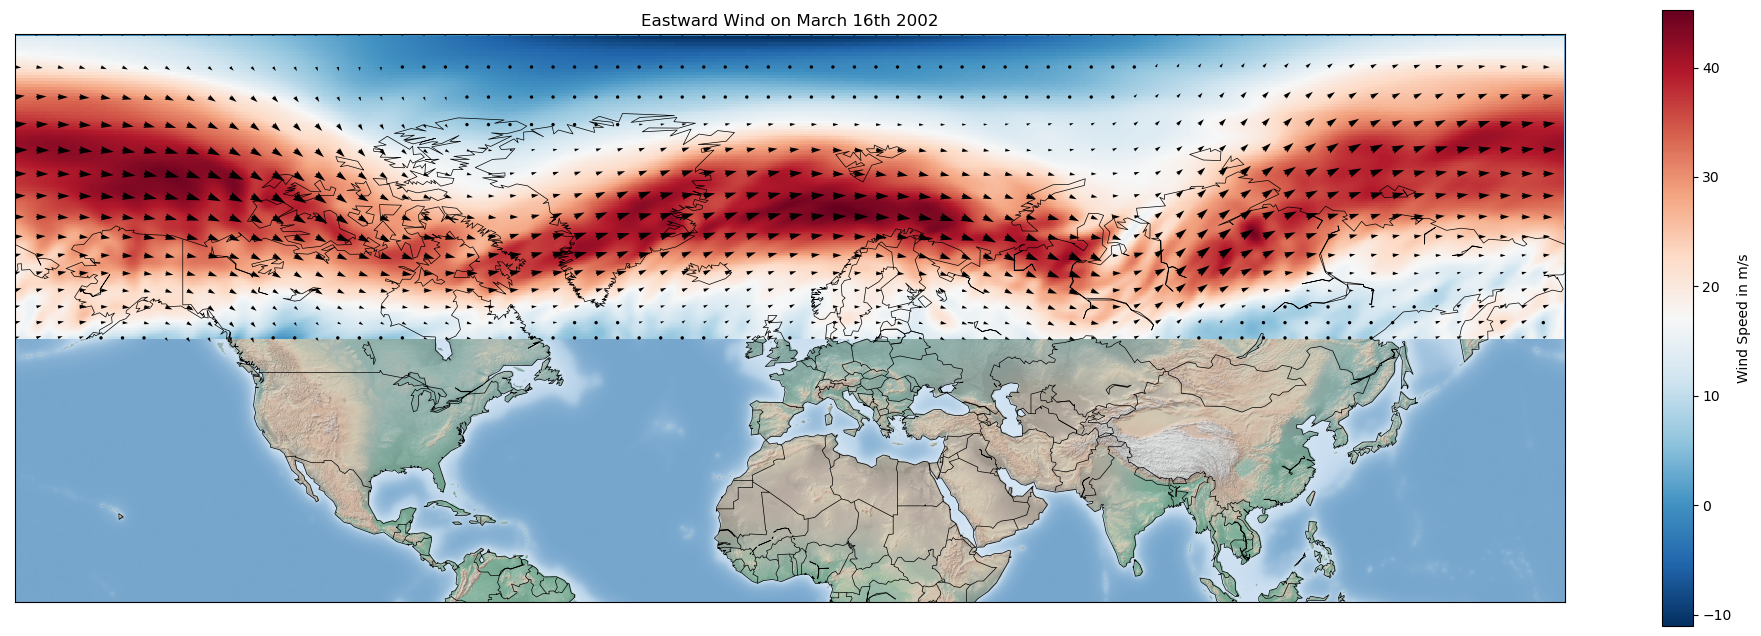

In [33]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

fig = plt.figure(figsize=(25, 8))

# use to plot north pole stero plot
# plot sterographic projection
# m = Basemap(projection='npstere',boundinglat=0,lon_0=0,resolution='c')

# plot miller projection
m = Basemap(projection='mill',
            llcrnrlat = 0,
            urcrnrlat = 90,
            llcrnrlon = -180,
            urcrnrlon =180)

m.shadedrelief(scale=0.5)

m.pcolormesh(grid.grid_[0], 
             grid.grid_[1], 
             data_u,
             latlon=True, cmap='RdBu_r',
             shading='auto')

x = grid.grid_[0][::10, ::20]
y = grid.grid_[1][::10, ::20]

data_u_d = data_u[::10, ::20]
data_v_d = data_v[::10, ::20]


m.quiver(x, y, 
     data_u_d, data_v_d,scale = 5000,latlon=True)


m.drawcoastlines(linewidth=0.5,linestyle='solid')
m.drawcountries(linewidth=0.5, linestyle='solid',color='k')

# change density of arrows

# plt.title('Eastward Wind on March 16th 2002')
plt.title('Eastward Wind on March 16th 2002')
plt.colorbar(label='Wind Speed in m/s')